In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
from ipyleaflet import Map, Marker, basemaps, basemap_to_tiles,Heatmap, LayersControl
from random import uniform

In [2]:
cd ..

/Users/alphonsowoodbury/DS/Projects/aw_flatiron_group_projects/Module3_Project


In [445]:
df = pd.read_csv('data/cleaned_water.csv',index_col=0)

df_b = df.copy()
df_b['status_group'] = df_b['status_group'].replace(to_replace =["functional needs repair", "non functional"],value ="needs repair")
df.amount_tsh = df.amount_tsh.astype('int64')
df_b.amount_tsh = df_b.amount_tsh.astype('int64')

---

## Target

Status Group

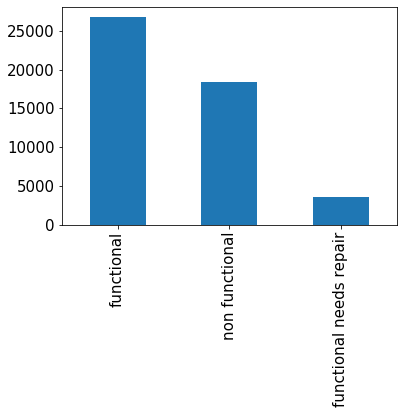

In [423]:
df.status_group.value_counts().plot(kind='bar',fontsize=15) #can this be a boxplot? #this is unbalanced

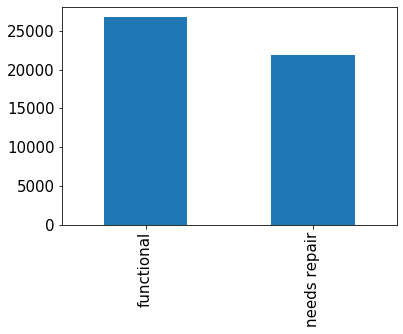

In [10]:
df_b.status_group.value_counts().plot(kind='bar',fontsize=15) #can this be a boxplot? #this is unbalanced

# Outliers: geographic?

In [424]:
df_g = df_b[df_b['longitude'] < 27.5]
df_g

,status_group,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,subvillage,region,...,permit,extraction_type_class,management,payment_type,water_quality,quantity,source,source_class,waterpoint_type,age
53,needs repair,0,Government Of Tanzania,0,Government,0.0,-2.000000e-08,Lake Victoria,Center,Mwanza,...,True,submersible,vwc,unknown,unknown,dry,machine dbh,groundwater,communal standpipe multiple,23
168,functional,0,Wvt,0,WVT,0.0,-2.000000e-08,Lake Victoria,Ilula,Shinyanga,...,False,gravity,parastatal,other,soft,seasonal,rainwater harvesting,surface,communal standpipe,23
256,needs repair,0,Hesawa,0,DWE,0.0,-2.000000e-08,Lake Victoria,Ujamaa,Mwanza,...,True,handpump,vwc,never pay,unknown,dry,machine dbh,groundwater,hand pump,23
301,functional,0,Government Of Tanzania,0,Government,0.0,-2.000000e-08,Lake Victoria,Nyanza,Mwanza,...,True,handpump,vwc,never pay,soft,insufficient,machine dbh,groundwater,hand pump,23
306,functional,0,Plan International,0,Plan Internationa,0.0,-2.000000e-08,Lake Victoria,Mwabasabi,Mwanza,...,True,handpump,vwc,never pay,soft,insufficient,machine dbh,groundwater,hand pump,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59135,functional,0,Hesawa,0,Hesawa,0.0,-2.000000e-08,Lake Victoria,Kagondo,Mwanza,...,True,handpump,vwc,never pay,soft,enough,shallow well,groundwater,hand pump,23
59158,functional,0,Wsdp,0,DWE,0.0,-2.000000e-08,Lake Victoria,Mwamanumbu,Shinyanga,...,False,handpump,wug,never pay,soft,enough,shallow well,groundwater,hand pump,23
59189,needs repair,0,Dwsp,0,DWE,0.0,-2.000000e-08,Lake Victoria,Mwamabuli,Shinyanga,...,False,handpump,wug,other,soft,enough,shallow well,groundwater,hand pump,23
59295,needs repair,0,Rwssp,0,DWE,0.0,-2.000000e-08,Lake Victoria,Mwamalizi,Shinyanga,...,False,handpump,wug,never pay,soft,enough,shallow well,groundwater,hand pump,23


In [425]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48651 entries, 0 to 59399
Data columns (total 27 columns):
status_group             48651 non-null object
amount_tsh               48651 non-null int64
funder                   48651 non-null object
gps_height               48651 non-null int64
installer                48651 non-null object
longitude                48651 non-null float64
latitude                 48651 non-null float64
basin                    48651 non-null object
subvillage               48288 non-null object
region                   48651 non-null object
region_code              48651 non-null int64
district_code            48651 non-null int64
lga                      48651 non-null object
ward                     48651 non-null object
population               48651 non-null int64
public_meeting           48651 non-null bool
scheme_management        48651 non-null object
permit                   48651 non-null bool
extraction_type_class    48651 non-null object
manag

In [426]:
df_g.longitude.value_counts()

0.0    1326
Name: longitude, dtype: int64

In [398]:
df_g.latitude.value_counts()

-2.000000e-08    1326
Name: latitude, dtype: int64

In [427]:
df_g.status_group.value_counts()

needs repair    740
functional      586
Name: status_group, dtype: int64

In [400]:
df_g.basin.value_counts()

Lake Victoria      1227
Lake Tanganyika      99
Name: basin, dtype: int64

In [430]:
df_g.district_code.value_counts()

1    699
6    481
2    146
Name: district_code, dtype: int64

In [408]:
df_g.region.value_counts()

Shinyanga    696
Mwanza       630
Name: region, dtype: int64

In [410]:
df_g.payment_type.value_counts()

never pay     856
unknown       152
other         146
monthly        66
on failure     58
per bucket     32
annually       16
Name: payment_type, dtype: int64

In [446]:
df_g.age.value_counts() #they were constructed the same year!

23    1326
Name: age, dtype: int64

In [416]:
df_region = df_b[df_b['region'].isin(['Mwanza','Shinyanga'])]
df_region.describe()

,amount_tsh,gps_height,longitude,latitude,population,age
count,6060.000000,6060.000000,6060.000000,6.060000e+03,6060.000000,6060.000000
mean,12.747525,58.748185,26.031266,-2.457621e+00,22.738944,23.083168
std,657.551982,270.886192,13.789511,1.364034e+00,142.321020,2.537980
min,0.000000,0.000000,0.000000,-4.381946e+00,0.000000,8.000000
25%,0.000000,0.000000,32.050238,-3.378984e+00,0.000000,23.000000
50%,0.000000,0.000000,33.160589,-2.985162e+00,0.000000,23.000000
75%,0.000000,0.000000,33.591704,-2.411232e+00,0.000000,23.000000
max,50000.000000,1434.000000,34.758734,-2.000000e-08,5000.000000,54.000000


In [401]:
df_l = df_b[df_b['basin']== 'Lake Victoria']
df_l

,status_group,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region,lga,...,management,payment_type,water_quality,quantity,source,source_class,waterpoint_type,age,tsh_bins,age_bucket
53,needs repair,0,Government Of Tanzania,0,Government,0.000000,-2.000000e-08,Lake Victoria,Mwanza,Geita,...,vwc,unknown,unknown,dry,machine dbh,groundwater,communal standpipe multiple,23,NaN,"(20, 30]"
59,needs repair,0,Government Of Tanzania,0,DWE,31.454282,-1.563886e+00,Lake Victoria,Kagera,Bukoba Rural,...,vwc,never pay,soft,enough,shallow well,groundwater,hand pump,23,NaN,"(20, 30]"
67,needs repair,0,Government Of Tanzania,0,DWE,30.716090,-1.285780e+00,Lake Victoria,Kagera,Karagwe,...,vwc,never pay,soft,dry,spring,groundwater,other,23,NaN,"(20, 30]"
85,needs repair,0,Swedish,0,Sengerema Water Department,32.185517,-2.378772e+00,Lake Victoria,Mwanza,Sengerema,...,vwc,never pay,soft,seasonal,shallow well,groundwater,hand pump,23,NaN,"(20, 30]"
94,needs repair,0,Hesawa,0,DWE,31.453111,-1.194390e+00,Lake Victoria,Kagera,Misenyi,...,vwc,never pay,milky,insufficient,shallow well,groundwater,hand pump,23,NaN,"(20, 30]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59371,needs repair,0,Netherlands,0,DWE,33.586406,-3.040369e+00,Lake Victoria,Shinyanga,Maswa,...,wug,never pay,soft,enough,shallow well,groundwater,hand pump,23,NaN,"(20, 30]"
59374,functional,0,Rwssp,0,DWE,0.000000,-2.000000e-08,Lake Victoria,Shinyanga,Bariadi,...,wug,other,soft,enough,shallow well,groundwater,hand pump,23,NaN,"(20, 30]"
59379,functional,0,Do,0,DO,31.613284,-1.820226e+00,Lake Victoria,Kagera,Muleba,...,vwc,never pay,soft,enough,spring,groundwater,communal standpipe,23,NaN,"(20, 30]"
59384,needs repair,0,Concern,0,CONCERN,30.667805,-2.483710e+00,Lake Victoria,Kagera,Ngara,...,vwc,never pay,soft,insufficient,spring,groundwater,communal standpipe,23,NaN,"(20, 30]"


In [404]:
df_l.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7321 entries, 53 to 59385
Data columns (total 26 columns):
status_group             7321 non-null object
amount_tsh               7321 non-null int64
funder                   7321 non-null object
gps_height               7321 non-null int64
installer                7321 non-null object
longitude                7321 non-null float64
latitude                 7321 non-null float64
basin                    7321 non-null object
region                   7321 non-null object
lga                      7321 non-null object
ward                     7321 non-null object
population               7321 non-null int64
public_meeting           7321 non-null bool
scheme_management        7321 non-null object
permit                   7321 non-null bool
extraction_type_class    7321 non-null object
management               7321 non-null object
payment_type             7321 non-null object
water_quality            7321 non-null object
quantity              

---

## Features

### Water

- A LOT of 0 values, impute?

#### Feature: Tsh Value

In [448]:
df.amount_tsh.value_counts(bins=10)

(-250.001, 25000.0]     48614
(25000.0, 50000.0]         21
(100000.0, 125000.0]        7
(75000.0, 100000.0]         3
(50000.0, 75000.0]          2
(225000.0, 250000.0]        1
(175000.0, 200000.0]        1
(150000.0, 175000.0]        1
(125000.0, 150000.0]        1
(200000.0, 225000.0]        0
Name: amount_tsh, dtype: int64

In [451]:
(df.amount_tsh == 0).sum() #this is a bad feature

32516

In [341]:
tshbins = range(0, df.amount_tsh.max(), 20000)
df['tsh_bins'] = pd.cut(df.amount_tsh, bins=tshbins)

status_group,functional,functional needs repair,non functional
tsh_bins,,,
"(0, 20000]",0.699981,0.074585,0.225434
"(20000, 40000]",0.880000,0.040000,0.080000
"(40000, 60000]",0.666667,0.166667,0.166667
"(60000, 80000]",1.000000,0.000000,0.000000
"(80000, 100000]",0.666667,0.333333,0.000000
"(100000, 120000]",0.857143,0.000000,0.142857
"(120000, 140000]",1.000000,0.000000,0.000000
"(160000, 180000]",1.000000,0.000000,0.000000
"(180000, 200000]",1.000000,0.000000,0.000000


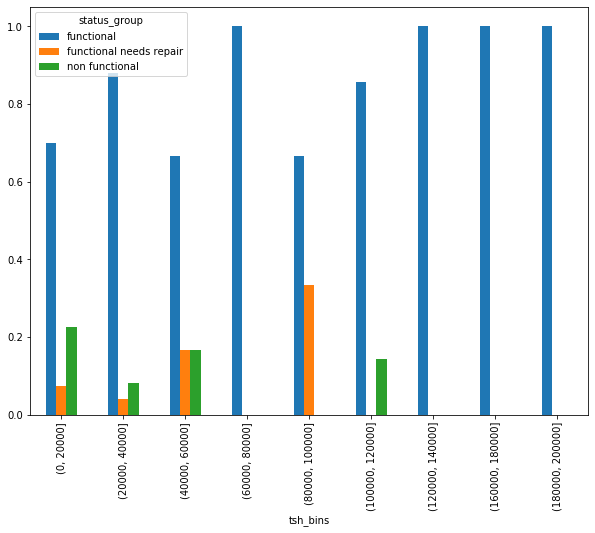

In [360]:
tshs = pd.crosstab(df.tsh_bins,df.status_group,normalize='index')
tshs.plot(kind='bar',figsize=(10,7.50),fontsize=10)
tshs

In [331]:
tshbinsb = range(2, df_b.amount_tsh.max(), 25000)
df_b['tsh_bins'] = pd.cut(df_b.amount_tsh, bins=tshbins)

status_group,functional,needs repair
tsh_bins,,
"(0, 20000]",0.699981,0.300019
"(20000, 40000]",0.880000,0.120000
"(40000, 60000]",0.666667,0.333333
"(60000, 80000]",1.000000,0.000000
"(80000, 100000]",0.666667,0.333333
"(100000, 120000]",0.857143,0.142857
"(120000, 140000]",1.000000,0.000000
"(160000, 180000]",1.000000,0.000000
"(180000, 200000]",1.000000,0.000000


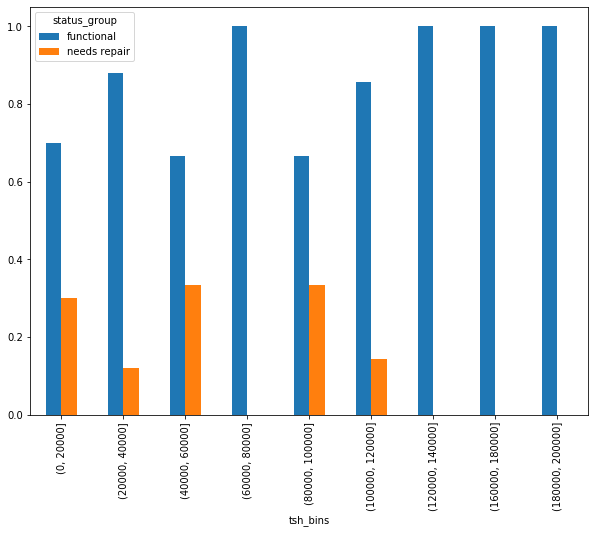

In [361]:
#df.groupby('tsh_bins').status_group.value_counts()
tshsb = pd.crosstab(df_b.tsh_bins,df_b.status_group,normalize='index')
tshsb.plot(kind='bar',figsize=(10,7.50),fontsize=10)
tshsb

#### Feature: Quality

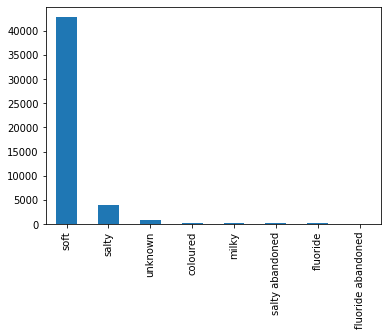

In [13]:
df.water_quality.value_counts().plot(kind='bar')

In [468]:
# watq = pd.crosstab(df.water_quality,df.status_group,normalize='index')
# watq.plot(kind='bar',figsize=(10,7.50),fontsize=10,rot=45)
# watq.sort_values('functional',ascending=False)

status_group,functional,needs repair
water_quality,,
fluoride,0.775000,0.225000
soft,0.568008,0.431992
milky,0.565217,0.434783
coloured,0.509375,0.490625
salty abandoned,0.456897,0.543103
salty,0.443343,0.556657
fluoride abandoned,0.307692,0.692308
unknown,0.104545,0.895455


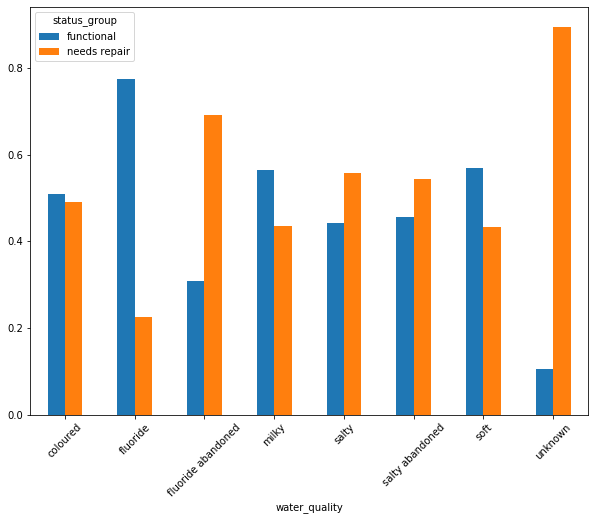

In [363]:
watqb = pd.crosstab(df_b.water_quality,df_b.status_group,normalize='index')
watqb.plot(kind='bar',figsize=(10,7.50),fontsize=10,rot=45)
watqb.sort_values('functional',ascending=False)

In [459]:
flo = df_b[df_b['water_quality'] == 'fluoride']
flo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 110 to 59159
Data columns (total 27 columns):
status_group             160 non-null object
amount_tsh               160 non-null int64
funder                   160 non-null object
gps_height               160 non-null int64
installer                160 non-null object
longitude                160 non-null float64
latitude                 160 non-null float64
basin                    160 non-null object
subvillage               160 non-null object
region                   160 non-null object
region_code              160 non-null int64
district_code            160 non-null int64
lga                      160 non-null object
ward                     160 non-null object
population               160 non-null int64
public_meeting           160 non-null bool
scheme_management        160 non-null object
permit                   160 non-null bool
extraction_type_class    160 non-null object
management               160 non-null objec

In [457]:
qualities = df.water_quality.value_counts().index.tolist()

In [458]:
for qual in qualities:
    mean = df[df['water_quality'] == qual].population.mean()
    print(qual+':' + str(mean))

soft:167.933241456635
salty:271.2799796747967
unknown:151.8181818181818
coloured:152.034375
milky:127.07357859531773
salty abandoned:95.78448275862068
fluoride:193.7375
fluoride abandoned:118.3076923076923


In [460]:
for qual in qualities:
    mean = df[df['water_quality'] == qual].age.mean()
    print(qual+':' + str(mean))

soft:23.184204994043586
salty:22.984756097560975
unknown:24.41590909090909
coloured:22.90625
milky:23.67558528428094
salty abandoned:23.198275862068964
fluoride:19.475
fluoride abandoned:20.615384615384617


In [479]:
for qual in qualities:
    mean = df[df['water_quality'] == qual].permit.mean()
    print('permit+'+qual+':' + str(mean))

permit+soft:0.7030202518044428
permit+salty:0.5251524390243902
permit+unknown:0.5659090909090909
permit+coloured:0.765625
permit+milky:0.6722408026755853
permit+salty abandoned:0.23706896551724138
permit+fluoride:0.90625
permit+fluoride abandoned:0.23076923076923078


In [470]:
for qual in qualities:
    mean = df[df['water_quality'] == qual].public_meeting.mean()
    print('public_meeting+'+qual+':' + str(mean))

public_meeting+soft:0.9143911611501717
public_meeting+salty:0.881859756097561
public_meeting+unknown:0.8875
public_meeting+coloured:0.84375
public_meeting+milky:0.8595317725752508
public_meeting+salty abandoned:0.8836206896551724
public_meeting+fluoride:1.0
public_meeting+fluoride abandoned:1.0


what are the populations around the abandoned waterpoints?

#### Feature: Quantity

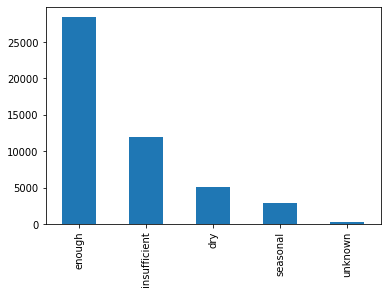

In [16]:
df.quantity.value_counts().plot(kind='bar')

status_group,functional,functional needs repair,non functional
quantity,,,
enough,0.655901,0.075912,0.268187
seasonal,0.569263,0.084769,0.345968
insufficient,0.522561,0.090160,0.387278
unknown,0.206897,0.006897,0.786207
dry,0.024687,0.003527,0.971787


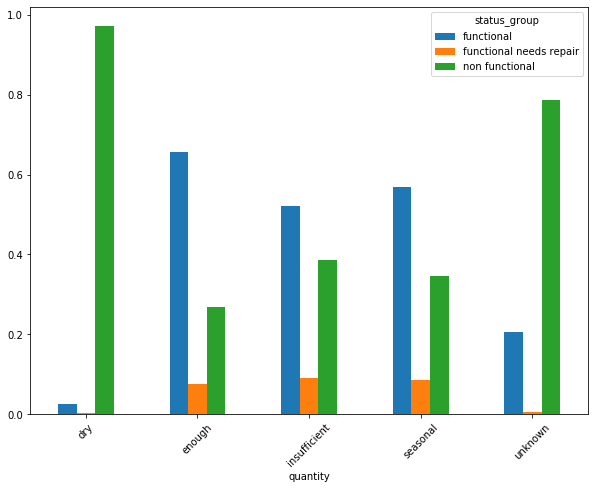

In [364]:
quant = pd.crosstab(df.quantity,df.status_group,normalize='index')
quant.plot(kind='bar',figsize=(10,7.50),fontsize=10,rot=45)
quant.sort_values('functional',ascending=False)

status_group,functional,needs repair
quantity,,
enough,0.655901,0.344099
seasonal,0.569263,0.430737
insufficient,0.522561,0.477439
unknown,0.206897,0.793103
dry,0.024687,0.975313


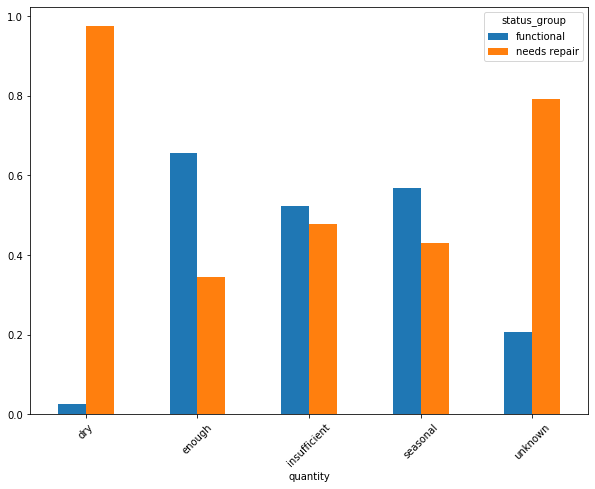

In [365]:
quantb = pd.crosstab(df_b.quantity,df_b.status_group,normalize='index')
quantb.plot(kind='bar',figsize=(10,7.50),fontsize=10,rot=45)
quantb.sort_values('functional',ascending=False)

#### Feature: Source

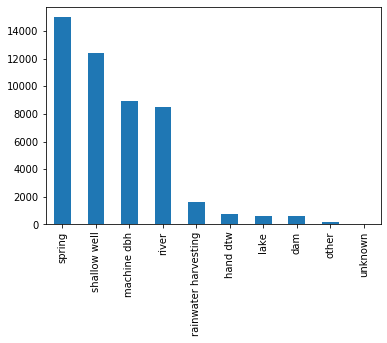

In [127]:
df.source.value_counts().plot(kind='bar')

status_group,functional,functional needs repair,non functional
source,,,
other,0.670330,0.005495,0.324176
spring,0.625742,0.071662,0.302596
river,0.584529,0.117799,0.297672
rainwater harvesting,0.581829,0.144368,0.273802
hand dtw,0.562259,0.019255,0.418485
Status of all Sources,0.549218,0.071920,0.378862
shallow well,0.500443,0.059998,0.439559
machine dbh,0.478280,0.044333,0.477387
unknown,0.468750,0.093750,0.437500


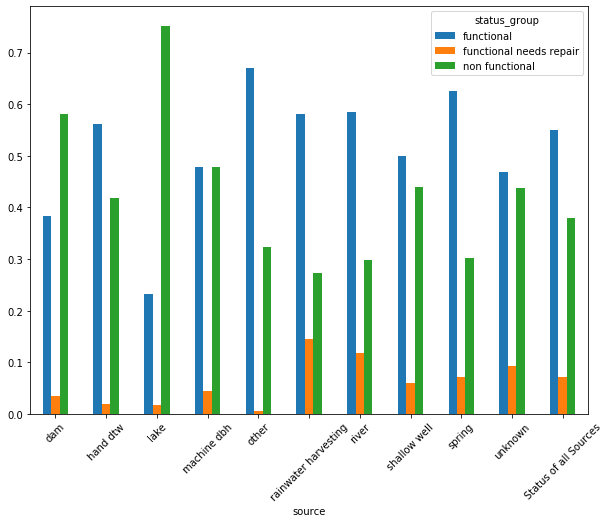

In [366]:
src = pd.crosstab(df.source,df.status_group,normalize='index',margins=True,margins_name='Status of all Sources')
src.plot(kind='bar',figsize=(10,7.50),fontsize=10,rot=45)
src.sort_values('functional',ascending=False)

status_group,functional,needs repair
source,,
other,0.670330,0.329670
spring,0.625742,0.374258
river,0.584529,0.415471
rainwater harvesting,0.581829,0.418171
hand dtw,0.562259,0.437741
Status of all Sources,0.549218,0.450782
shallow well,0.500443,0.499557
machine dbh,0.478280,0.521720
unknown,0.468750,0.531250


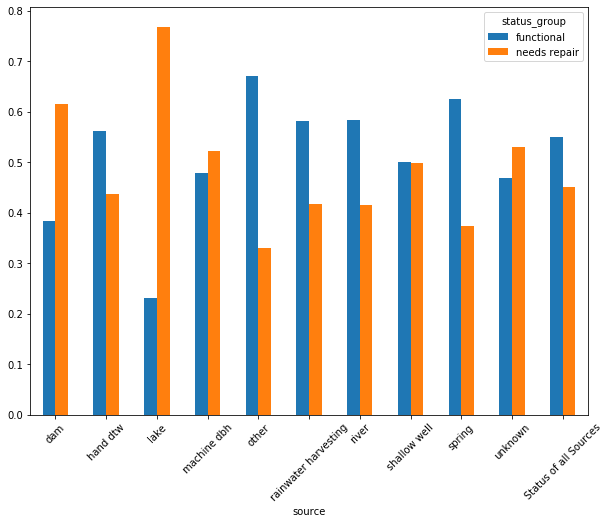

In [367]:
srcb = pd.crosstab(df_b.source,df_b.status_group,normalize='index',margins=True,margins_name='Status of all Sources')
srcb.plot(kind='bar',figsize=(10,7.50),fontsize=10,rot=45)
srcb.sort_values('functional',ascending=False)

#### Source Class

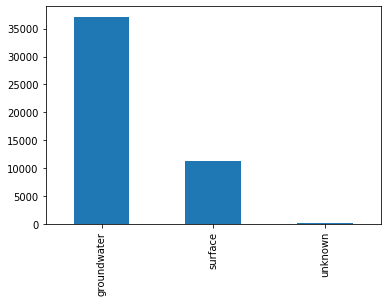

In [22]:
df.source_class.value_counts().plot(kind='bar')

status_group,functional,functional needs repair,non functional
source_class,,,
unknown,0.640187,0.018692,0.341121
surface,0.554916,0.111868,0.333215
All,0.549218,0.071920,0.378862
groundwater,0.546960,0.060073,0.392967


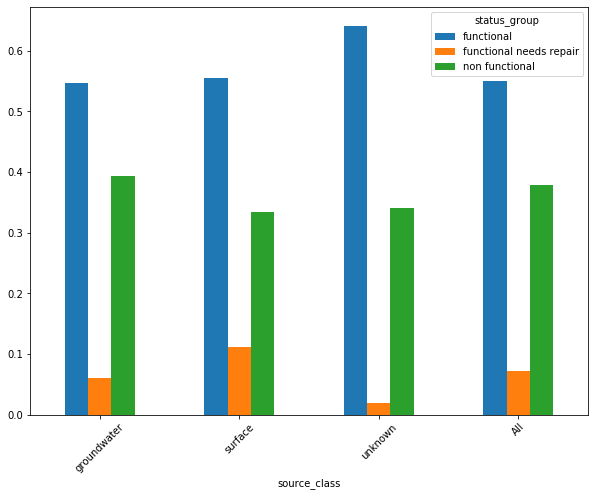

In [368]:
srcc = pd.crosstab(df.source_class,df.status_group,margins=True,normalize='index')#
srcc.plot(kind='bar',figsize=(10,7.5),rot=45)
srcc.sort_values('functional',ascending=False)

status_group,functional,needs repair
source_class,,
unknown,0.640187,0.359813
surface,0.554916,0.445084
All,0.549218,0.450782
groundwater,0.546960,0.453040


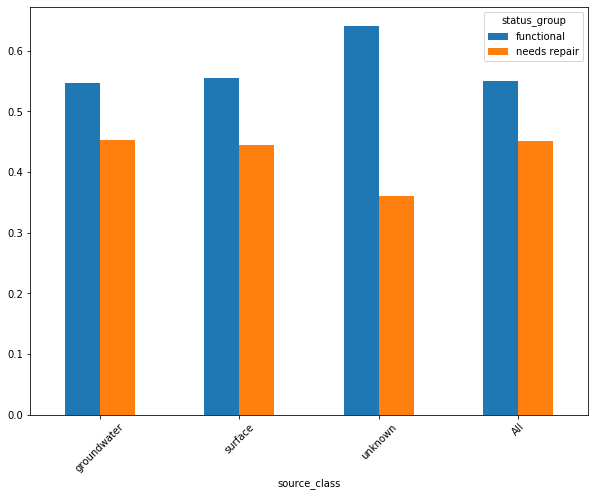

In [369]:
srccb = pd.crosstab(df_b.source_class,df_b.status_group,margins=True,normalize='index')#
srccb.plot(kind='bar',figsize=(10,7.5),rot=45)
srccb.sort_values('functional',ascending=False)

#### Feature: Basin

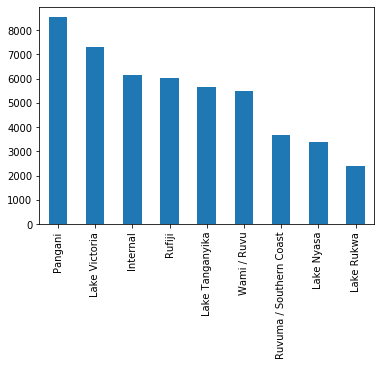

In [24]:
df.basin.value_counts().plot(kind='bar')

status_group,functional,needs repair
basin,,
Lake Nyasa,0.692239,0.307761
Rufiji,0.668380,0.331620
Pangani,0.602927,0.397073
Internal,0.601625,0.398375
All,0.549218,0.450782
Wami / Ruvu,0.510386,0.489614
Lake Victoria,0.493102,0.506898
Lake Tanganyika,0.477132,0.522868
Lake Rukwa,0.411324,0.588676


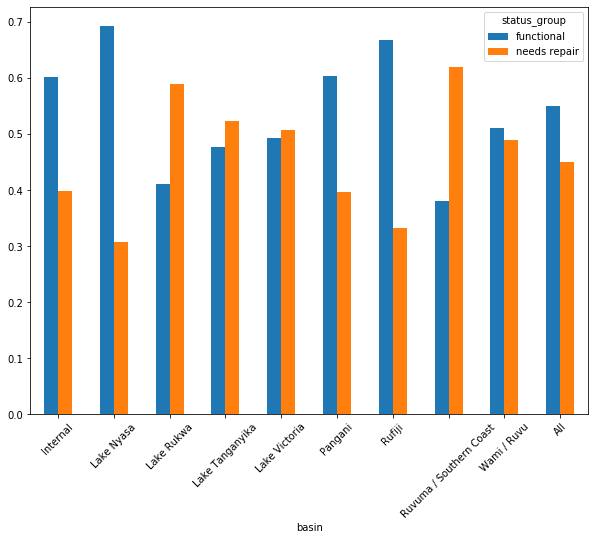

In [467]:
basin = pd.crosstab([df_b.basin],df_b.status_group,margins=True,normalize='index')#
basin.plot(kind='bar',figsize=(10,7.5),rot=45)
basin.sort_values('functional',ascending=False)

do they have different water?

### Waterpoint

#### Feature: Waterpoint Age

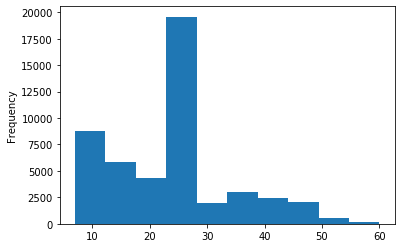

In [26]:
df.age.plot(kind='hist') #knn? 

In [371]:
agebins = range(0, df.age.max(), 10)
df['age_bucket'] = pd.cut(df.age, bins=agebins)

status_group,functional,functional needs repair,non functional
age_bucket,,,
"(0, 10]",0.733616,0.045851,0.220533
"(10, 20]",0.661978,0.063445,0.274577
"(20, 30]",0.519066,0.077709,0.403226
"(30, 40]",0.421561,0.079261,0.499179
"(40, 50]",0.335172,0.083480,0.581349


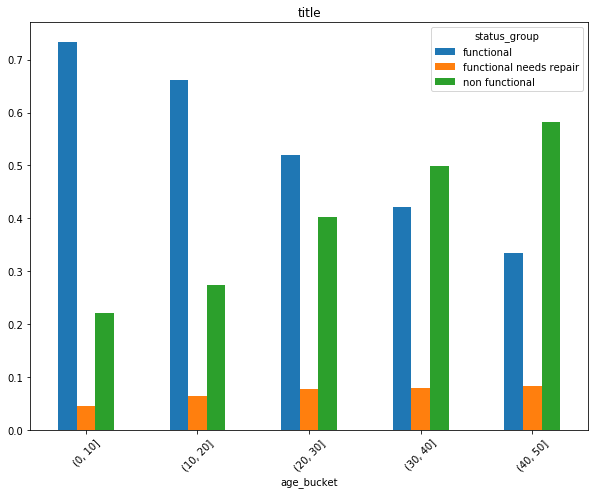

In [372]:
ages = pd.crosstab(df.age_bucket,df.status_group,normalize='index')
ages.plot(kind='bar',figsize=(10,7.5),title='title',rot=45)
ages

###### **Binary**

In [374]:
mybins = range(0, df_b.age.max(), 10)
df_b['age_bucket'] = pd.cut(df_b.age, bins=mybins)

status_group,functional,needs repair
age_bucket,,
"(0, 10]",0.733616,0.266384
"(10, 20]",0.661978,0.338022
"(20, 30]",0.519066,0.480934
"(30, 40]",0.421561,0.578439
"(40, 50]",0.335172,0.664828


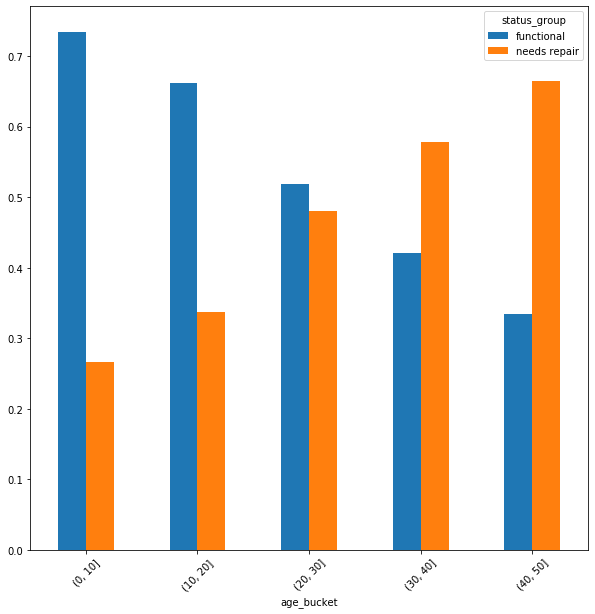

In [375]:
ages_b = pd.crosstab(df_b.age_bucket,df_b.status_group,normalize='index')
ages_b.plot(kind='bar',figsize=(10,10),rot=45)
ages_b

did the technology change?

#### Feature: Waterpoint Type

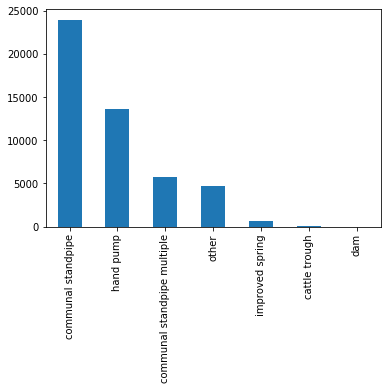

In [36]:
df.waterpoint_type.value_counts().plot(kind='bar')

status_group,functional,functional needs repair,non functional
waterpoint_type,,,
dam,1.000000,0.000000,0.000000
cattle trough,0.756098,0.024390,0.219512
improved spring,0.721966,0.102919,0.175115
communal standpipe,0.631221,0.073564,0.295215
hand pump,0.616306,0.059624,0.324070
communal standpipe multiple,0.370156,0.110644,0.519200
other,0.122234,0.048550,0.829216


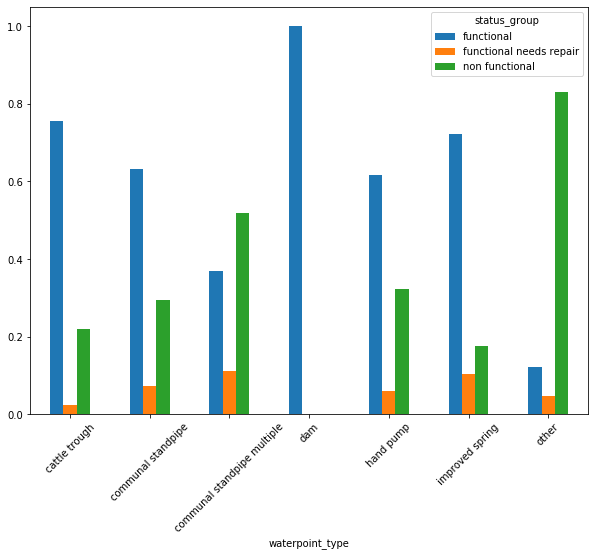

In [376]:
wpttp = pd.crosstab(df.waterpoint_type,df.status_group,normalize='index')
wpttp.plot(kind='bar',figsize=(10,7.5),rot=45)
wpttp.sort_values('functional',ascending=False)

###### **Binary**

status_group,functional,needs repair
waterpoint_type,,
dam,1.000000,0.000000
cattle trough,0.756098,0.243902
improved spring,0.721966,0.278034
communal standpipe,0.631221,0.368779
hand pump,0.616306,0.383694
communal standpipe multiple,0.370156,0.629844
other,0.122234,0.877766


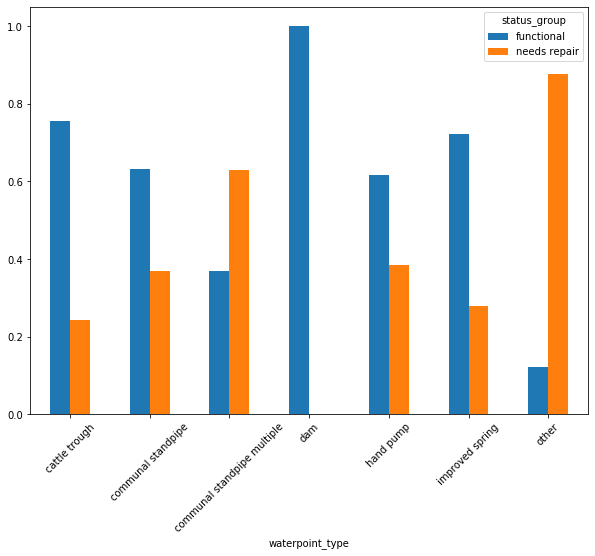

In [377]:
wpttpb = pd.crosstab(df_b.waterpoint_type,df_b.status_group,normalize='index')
wpttpb.plot(kind='bar',figsize=(10,7.5),rot=45)
wpttpb.sort_values('functional',ascending=False)

#### Extraction Type

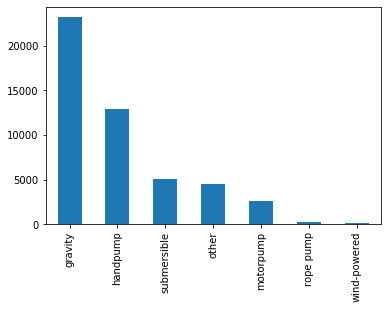

In [136]:
df.extraction_type_class.value_counts().plot(kind='bar')

status_group,functional,functional needs repair,non functional
extraction_type_class,,,
rope pump,0.636792,0.033019,0.330189
handpump,0.629644,0.061068,0.309288
gravity,0.609020,0.097151,0.293828
submersible,0.521346,0.040134,0.438521
wind-powered,0.413462,0.067308,0.519231
motorpump,0.394275,0.045038,0.560687
other,0.134963,0.027081,0.837957


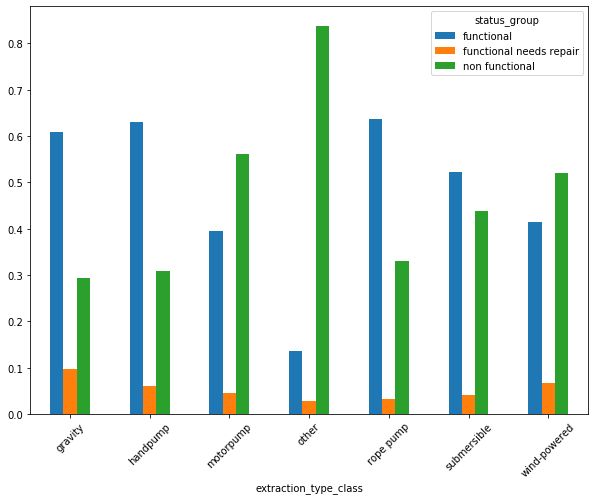

In [378]:
exttp = pd.crosstab(df.extraction_type_class,df.status_group,normalize='index')
exttp.plot(kind='bar',figsize=(10,7.5),rot=45)
exttp.sort_values('functional',ascending=False)

###### **Binary**

status_group,functional,needs repair
extraction_type_class,,
rope pump,0.636792,0.363208
handpump,0.629644,0.370356
gravity,0.609020,0.390980
submersible,0.521346,0.478654
wind-powered,0.413462,0.586538
motorpump,0.394275,0.605725
other,0.134963,0.865037


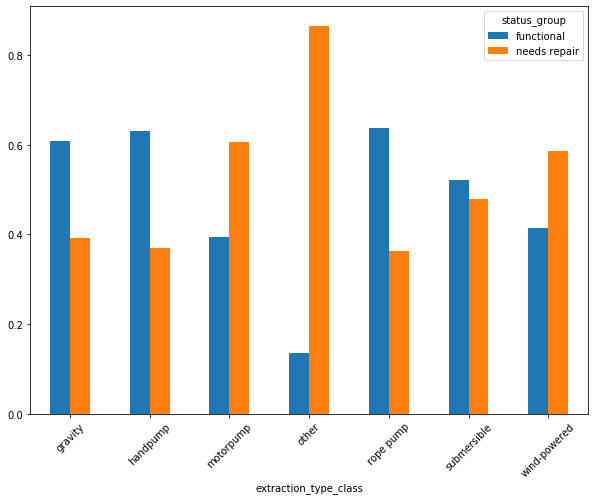

In [355]:
exttpb = pd.crosstab(df_b.extraction_type_class,df_b.status_group,normalize='index')
exttpb.plot(kind='bar',figsize=(10,7.5),rot=45)
exttpb.sort_values('functional',ascending=False)

### Governance

#### Feature: Permit

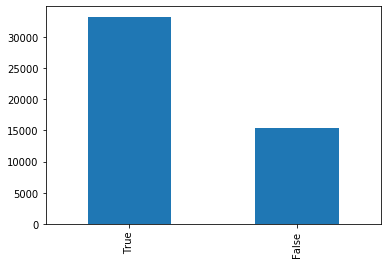

In [40]:
df.permit.value_counts().plot(kind='bar')

status_group,functional,functional needs repair,non functional
permit,,,
True,0.568521,0.068866,0.362613
False,0.507301,0.078553,0.414146


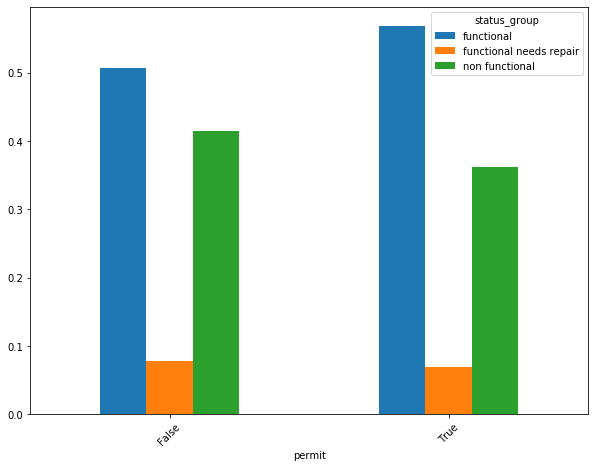

In [433]:
permit = pd.crosstab(df.permit,df.status_group,normalize='index')
permit.plot(kind='bar',figsize=(10,7.5),rot=45)
permit.sort_values('functional',ascending=False)

status_group,functional,needs repair
permit,,
True,0.568521,0.431479
False,0.507301,0.492699


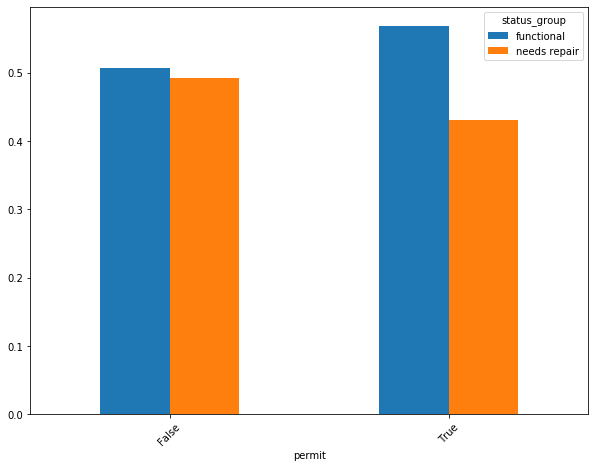

In [432]:
permitb = pd.crosstab(df_b.permit,df_b.status_group,normalize='index')
permitb.plot(kind='bar',figsize=(10,7.5),rot=45)
permitb.sort_values('functional',ascending=False)

#### Feature: Public Meeting

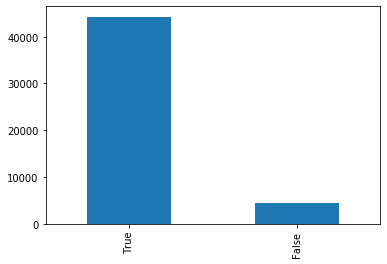

In [43]:
df.public_meeting.value_counts().plot(kind='bar')

status_group,functional,functional needs repair,non functional
public_meeting,,,
True,0.562784,0.070514,0.366702
False,0.410994,0.086247,0.502760


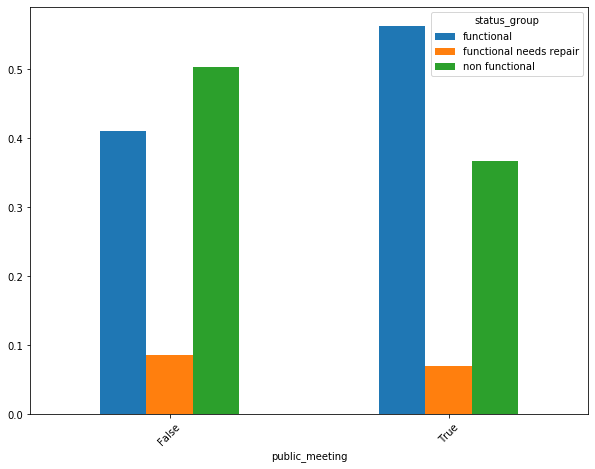

In [434]:
meet = pd.crosstab(df.public_meeting,df.status_group,normalize='index')
meet.plot(kind='bar',figsize=(10,7.5),rot=45)
meet.sort_values('functional',ascending=False)

status_group,functional,needs repair
public_meeting,,
True,0.562784,0.437216
False,0.410994,0.589006


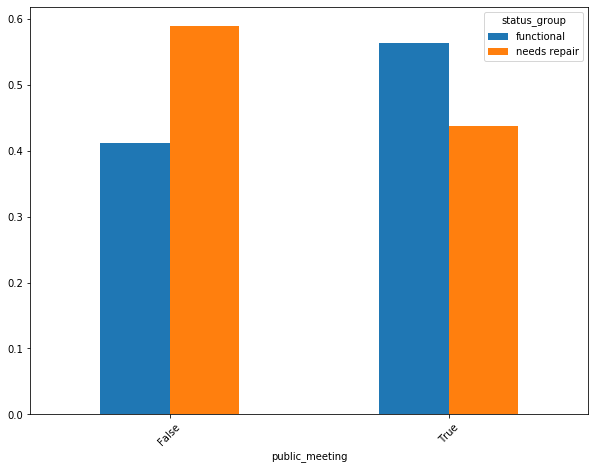

In [435]:
meetb = pd.crosstab(df_b.public_meeting,df_b.status_group,normalize='index')
meetb.plot(kind='bar',figsize=(10,7.5),rot=45)
meetb.sort_values('functional',ascending=False)

#### Feature: Mangagement

#### Feature: Funder

gpsheaight; a mountain? outlier?
longitude, are there errors? shouldnt be so far from the rest
construction year issues


In [173]:
top10funders = df['funder'].value_counts().index.tolist()[:11]
top10funders

['Government Of Tanzania',
 'Danida',
 'Hesawa',
 'Kkkt',
 'World Bank',
 'World Vision',
 'Unicef',
 'Rwssp',
 'District Council',
 'Tasaf',
 'Private Individual']

status_group,functional,needs repair
funder,,
Private Individual,0.843546,0.156454
Rwssp,0.593516,0.406484
World Vision,0.589080,0.410920
Unicef,0.589055,0.410945
Danida,0.570890,0.429110
Tasaf,0.559085,0.440915
Kkkt,0.559080,0.440920
District Council,0.456929,0.543071
Hesawa,0.448524,0.551476


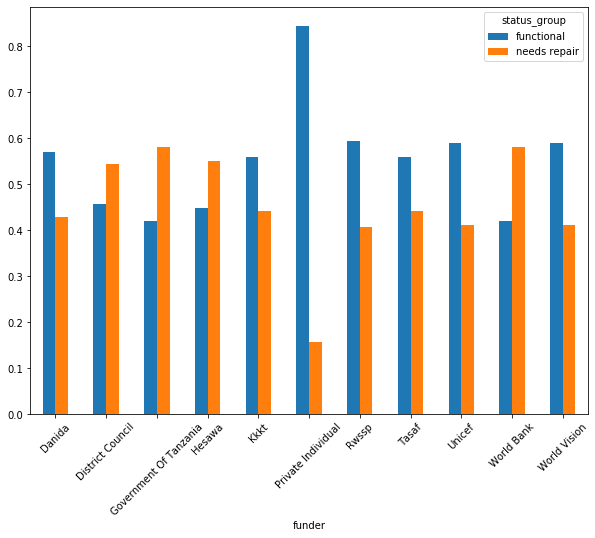

In [380]:
df_f = df_b[df_b['funder'].isin(top10funders)]
funders = pd.crosstab(df_f.funder,df_f.status_group,normalize='index')
funders.plot(kind='bar',figsize=(10,7.5),rot=45)
funders.sort_values('functional',ascending=False)

In [439]:
priv = df_b[df_b['funder'] == 'Private Individual']
priv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 767 entries, 31 to 59325
Data columns (total 27 columns):
status_group             767 non-null object
amount_tsh               767 non-null int64
funder                   767 non-null object
gps_height               767 non-null int64
installer                767 non-null object
longitude                767 non-null float64
latitude                 767 non-null float64
basin                    767 non-null object
subvillage               766 non-null object
region                   767 non-null object
region_code              767 non-null int64
district_code            767 non-null int64
lga                      767 non-null object
ward                     767 non-null object
population               767 non-null int64
public_meeting           767 non-null bool
scheme_management        767 non-null object
permit                   767 non-null bool
extraction_type_class    767 non-null object
management               767 non-null object

In [442]:
priv.age.value_counts(bins=10) ##most privately funded waterpoints were built in the last 20 years

(7.947, 13.2]    390
(13.2, 18.4]     227
(18.4, 23.6]     114
(28.8, 34.0]       9
(44.4, 49.6]       8
(34.0, 39.2]       8
(23.6, 28.8]       7
(54.8, 60.0]       2
(39.2, 44.4]       2
(49.6, 54.8]       0
Name: age, dtype: int64

In [443]:
priv.extraction_type_class.value_counts()

submersible     439
gravity         192
motorpump        48
handpump         47
other            34
wind-powered      4
rope pump         3
Name: extraction_type_class, dtype: int64

In [444]:
df_b.extraction_type_class.value_counts()

gravity         23170
handpump        12920
submersible      5083
other            4542
motorpump        2620
rope pump         212
wind-powered      104
Name: extraction_type_class, dtype: int64

#### Feature: Installer

In [234]:
df.installer.value_counts()

DWE                   14670
Government             1438
Commu                  1059
RWE                    1032
KKKT                    885
                      ...  
TWESA/JAMII               1
LEI                       1
Kwamdulu estate           1
GLOBAL RESOURCE CO        1
DAWE                      1
Name: installer, Length: 1799, dtype: int64

In [199]:
top10installers = df.installer.value_counts().index.tolist()[:11]
top10installers

['DWE',
 'Government',
 'Commu',
 'RWE',
 'KKKT',
 'DANIDA',
 'TCRS',
 'Central government',
 'CES',
 'Hesawa',
 'DANID']

status_group,functional,needs repair
installer,,
CES,0.881967,0.118033
DANID,0.780797,0.219203
Commu,0.682720,0.317280
Hesawa,0.617857,0.382143
DANIDA,0.580720,0.419280
DWE,0.550511,0.449489
KKKT,0.466667,0.533333
TCRS,0.399701,0.600299
Government,0.276773,0.723227


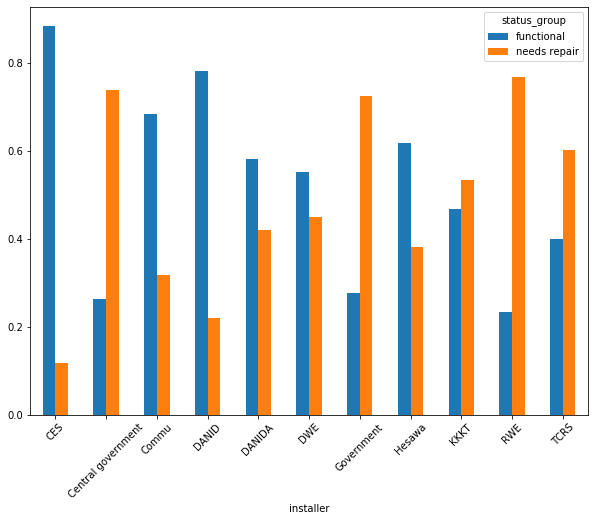

In [381]:
df_i = df_b[df_b['installer'].isin(top10installers)]
installers = pd.crosstab([df_i.installer],df_i.status_group,normalize='index')
installers.plot(kind='bar',figsize=(10,7.5),rot=45)
installers.sort_values('functional',ascending=False)

status_group,functional,needs repair
installer,,
ACRA,0.978339,0.021661
Magadini-Makiwaru wa,0.977143,0.022857
Dmdd,0.964789,0.035211
Co,0.945455,0.054545
St,0.944444,0.055556
Oikos E .Africa,0.937500,0.062500
Lawatefuka water sup,0.933333,0.066667
DAWASCO,0.921875,0.078125
Losaa-Kia water supp,0.919355,0.080645


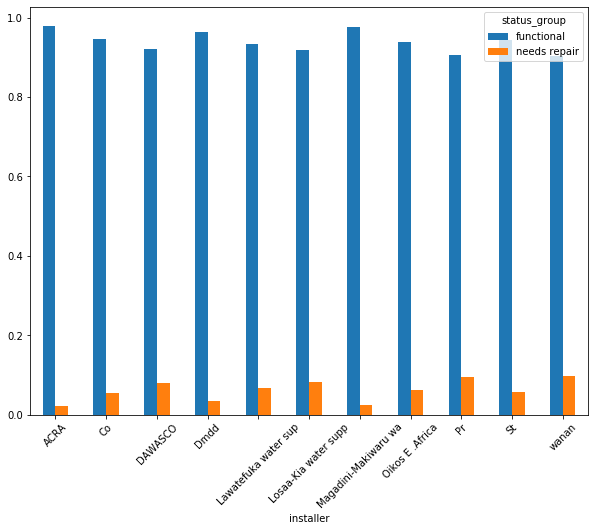

In [382]:
top100installers = df.installer.value_counts().index.tolist()[:135]
df_i2 = df_b[df_b['installer'].isin(top100installers)]
installers100 = pd.crosstab([df_i2.installer],df_i2.status_group,normalize='index')
installers100 = installers100[installers100['functional'] > 0.90]
installers100.plot(kind='bar',figsize=(10,7.5),rot=45)
installers100.sort_values('functional',ascending=False)

In [301]:
installers90club = installers100.index.tolist()
inst90clb = df_b[df_b['installer'].isin(installers90club)]

In [292]:
inst90clb.installer.value_counts()

Dmdd                    284
ACRA                    277
Lawatefuka water sup    180
Magadini-Makiwaru wa    175
Oikos E .Africa          80
DAWASCO                  64
Losaa-Kia water supp     62
Co                       55
St                       54
Pr                       53
wanan                    52
Name: installer, dtype: int64

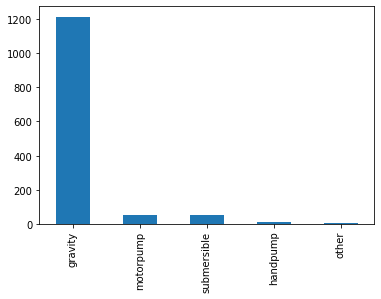

In [271]:
inst90clb.extraction_type_class.value_counts().plot(kind='bar')

(<matplotlib.axes._subplots.AxesSubplot at 0x1a37bf8240>,)

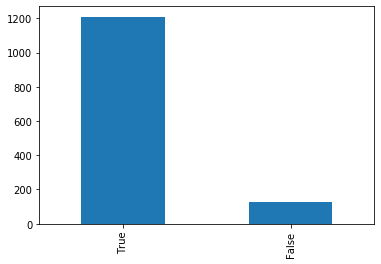

In [273]:
inst90clb.permit.value_counts().plot(kind='bar'),

(<matplotlib.axes._subplots.AxesSubplot at 0x1a388e2358>,)

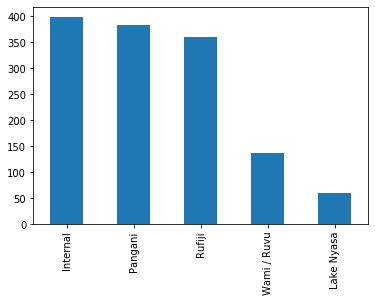

In [280]:
inst90clb.basin.value_counts().plot(kind='bar'),

(<matplotlib.axes._subplots.AxesSubplot at 0x1a387fdbe0>,)

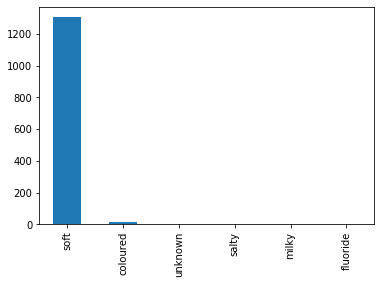

In [277]:
inst90clb.water_quality.value_counts().plot(kind='bar'), #NOTE: the most effective installers may be most effective because of the water quality

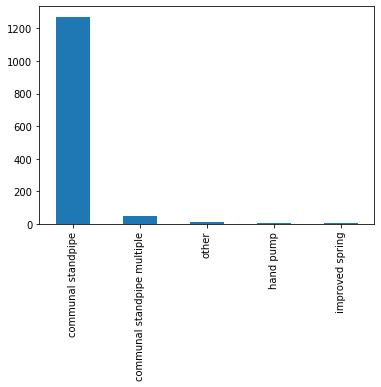

In [276]:
inst90clb.waterpoint_type.value_counts().plot(kind='bar')

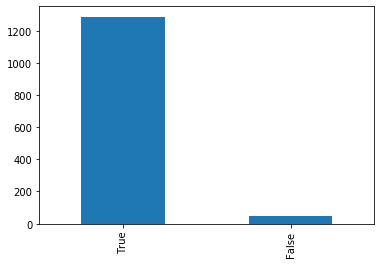

In [287]:
inst90clb.public_meeting.value_counts().plot(kind='bar')

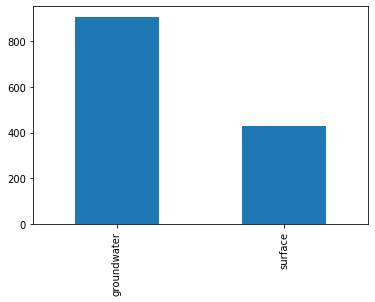

In [284]:
inst90clb.source_class.value_counts().plot(kind='bar')

Analysis: waterpoints with **soft water**,**groundwater or surface**, **permitted**,at a **communal standpipe** functioning with **gravity** are 90% operational when installed by the inst90clb

### Feature: Scheme

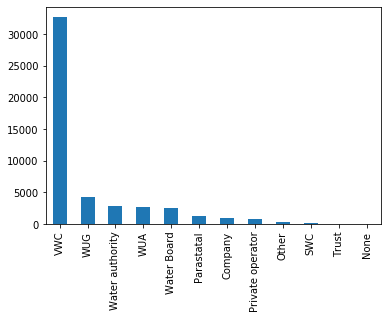

In [49]:
df.scheme_management.value_counts().plot(kind='bar')

---

status_group,functional,needs repair
management,,
water board,0.752720,0.247280
wua,0.714598,0.285402
private operator,0.712121,0.287879
wug,0.615145,0.384855
trust,0.586667,0.413333
parastatal,0.561983,0.438017
other,0.532294,0.467706
vwc,0.510888,0.489112
water authority,0.496871,0.503129


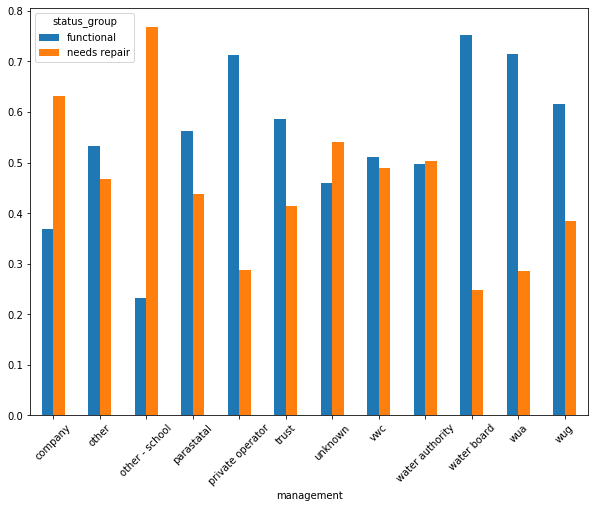

In [383]:
mgmt = pd.crosstab([df_b.management],df_b.status_group,normalize='index')
mgmt.plot(kind='bar',figsize=(10,7.5),rot=45)
mgmt.sort_values('functional',ascending=False)